# 🏠 Load libraries & data 🏠

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedStratifiedKFold,StratifiedKFold, RepeatedKFold
from scipy.stats import boxcox, median_abs_deviation 
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, RFECV, SelectKBest
from sklearn.decomposition import PCA

import tensorflow as tf

import shap 
import lightgbm as lgb
import catboost as cat
import xgboost as xgb
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from imblearn.over_sampling import SMOTE

In [2]:
target = "Strength" #Target column that we will be predicting, this is here for quick reference 

# Different scaling options
SCALING = False
DISTRIBUTION = True
OUTLIERS= True

# Feature engineering and model training options
ADD_DATA = True
TEST_ON_GENERATED_ONLY = True
EPOCHS= 2000

NUM_FOLDS = 5
NUM_SPLITS = 3

SHAP_VALS = False
CALIBRATION = "linear"

# Notebook settings
sns.set_style("darkgrid")
pd.set_option('mode.chained_assignment',None)

### Load data

In [3]:
df_train = pd.read_csv("/kaggle/input/playground-series-s3e9/train.csv", index_col = 0)
df_test = pd.read_csv("/kaggle/input/playground-series-s3e9/test.csv", index_col = 0)
sub = pd.read_csv("/kaggle/input/playground-series-s3e9/sample_submission.csv",index_col = 0)
df_train

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
id,,,,,,,,,
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
...,...,...,...,...,...,...,...,...,...
5402,446.0,24.0,79.0,162.0,11.6,967.0,712.0,3,15.42
5403,350.0,0.0,0.0,203.0,0.0,974.0,775.0,180,49.20
5404,295.8,0.0,0.0,185.7,0.0,1076.2,759.3,28,39.30


In [4]:
if ADD_DATA:
    add_data = pd.read_csv('/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv')
    
    print("length of additional data", len(add_data))
    print("length of original data", len(df_train))
    df_train['is_generated'] = 1
    df_test['is_generated'] = 1
    add_data['is_generated'] = 0
    add_data.columns =df_train.columns

    df_train = pd.concat([df_train, add_data],axis=0, ignore_index=True)
df_train

length of additional data 1030
length of original data 5407


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1
...,...,...,...,...,...,...,...,...,...,...
6432,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0
6433,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0
6434,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0
6435,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0


### Set Project Parameters
Below we set parameters that we will use to re-run this notebook with different aspects 

In [5]:
def base_model(X_trn,y_trn,X_tst,y_tst, name,model_in, X_in, test_in, print_scores = True):
    
    if name in ["lightgbm"]:
        model_in.fit(X_trn,y_trn,
              eval_set=[(X_tst,y_tst)],
              callbacks= [lgb.log_evaluation(-1), lgb.early_stopping(30)])
        
    elif name in ["xgboost"]:
        model_in.fit(X_trn,y_trn,
                     eval_set=[(X_tst,y_tst)],
                  verbose= 0
                 )
    elif name in ["catboost"]:
        model_in.fit(X_trn,y_trn,
                  eval_set=[(X_tst,y_tst)],
                  early_stopping_rounds=30,
                  verbose= 0
                 )          
    elif name in ["nn"]:
        model_in.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.006) 
                 )
        model_in.fit(X_trn,y_trn,epochs=EPOCHS,
                     callbacks=[early_stopping,reduce_lr],
                     validation_data=(X_tst, y_tst), verbose=0)
        
    else:
        model_in.fit(X_trn,y_trn)

    val_preds = model_in.predict(X_tst)
    trn_preds = model_in.predict(X_in)
    test_preds = model_in.predict(test_in)
    
    score_trn =mean_squared_error(y, trn_preds)**0.5
    score_val = mean_squared_error(y_tst, val_preds )**0.5
    
    if print_scores:
        print("\nTrn Score:",score_trn)
        print("Val Score:",score_val)
        #print("Val logloss", log_loss(y,trn_preds_base))
    
    return np.ravel(test_preds), np.ravel(trn_preds), np.ravel(val_preds), score_trn, score_val, model_in

In [6]:
def Scaling(X_train, X_test, test_df, X= None,) : 
    
    """Scaling and Sampling Helper function: 
        Scales and oversamples training and validation dataframes 
    
    :param 
        X_train: pandas dataframe of training data , less target values
        X_test: pandas dataframe of validation data , less target values
        test_df: pandas dataframe of test data , less target values
        y_train: pandas dataframe or series of target training values
        X: pandas dataframe of training and validation data, less target values
        
    :return: scaled input paramaters as pandas dataframes 

    """
    
    test_s = test_df.copy(deep = True)
    X_train_s = X_train.copy(deep = True)
    X_test_s = X_test.copy(deep = True)
    
    if X is not None:
        X_s = X.copy(deep = True)
    
    if OUTLIERS and len(outliers)>0:
        #Scale outliers: see boxplots
        scaler = RobustScaler()
        X_train_s[outliers] = scaler.fit_transform(X_train_s[outliers])
        X_test_s[outliers]  = scaler.transform(X_test_s[outliers])
        test_s[outliers] = scaler.transform(test_s[outliers])
        if X is not None:
            X_s[outliers] = scaler.transform(X_s[outliers])
    
    if DISTRIBUTION:
        #Scale Skewness: see distribution
        scaler = QuantileTransformer(output_distribution="normal")
        X_train_s[non_dist_cols] = scaler.fit_transform(X_train_s[non_dist_cols])
        X_test_s[non_dist_cols] = scaler.transform(X_test_s[non_dist_cols])
        test_s[non_dist_cols] = scaler.transform(test_s[non_dist_cols])
        if X is not None:
            X_s[non_dist_cols] = scaler.transform(X_s[non_dist_cols])
            
    if SCALING: 
        scaler = StandardScaler()
        X_train_s[scaled_cols] = scaler.fit_transform(X_train_s[scaled_cols])
        X_test_s[scaled_cols] = scaler.transform(X_test_s[scaled_cols])
        test_s[scaled_cols] = scaler.transform(test_s[scaled_cols])
        if X is not None:
            X_s[scaled_cols] = scaler.transform(X_s[scaled_cols])

              
    if X is not None:
        return pd.DataFrame(X_train_s, columns = X.columns )   , pd.DataFrame(X_test_s, columns = X.columns ) , pd.DataFrame(test_s, columns = test_df.columns ) , pd.DataFrame(X_s, columns = X.columns )  
    else:
        return pd.DataFrame(X_train_s, columns = X.columns ), pd.DataFrame(X_test_s, columns = X.columns )  , pd.DataFrame(test_s, columns = test_df.columns )

In [7]:
def SMAPE(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

# 📃 Quick Analysis 📃

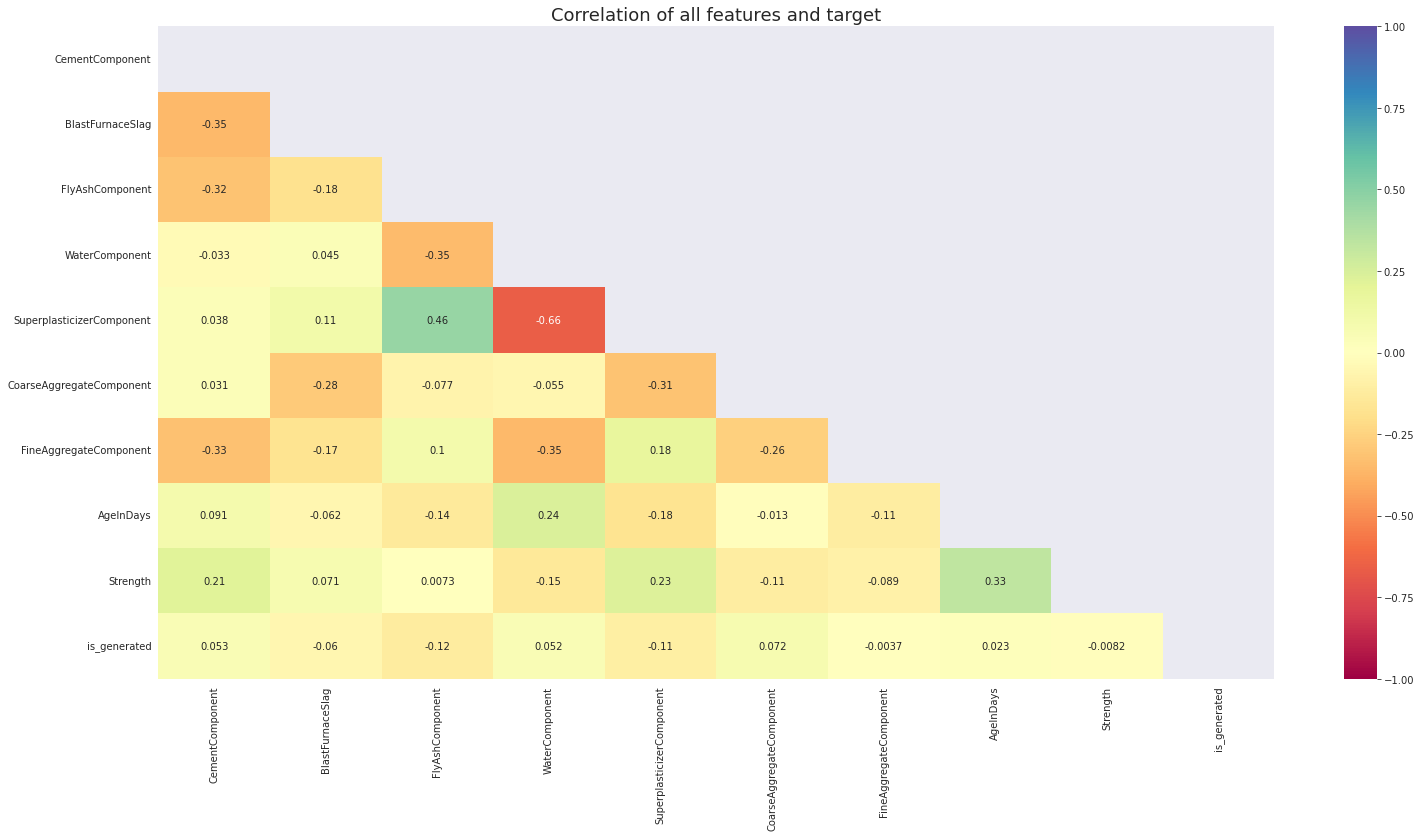

In [8]:
plt.figure(figsize = (25,12))

corr = pd.concat((df_train, df_test), axis =0).corr()
upper_triangle = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,vmin = -1, vmax = 1, cmap = "Spectral", annot = True, mask = upper_triangle)
plt.title("Correlation of all features and target", fontsize= 18)
plt.show()

# 🎯 Feature Engineering 🎯

In [9]:
df_trn = df_train.copy(deep = True)
df_tst = df_test.copy(deep = True)
df_trn

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1
...,...,...,...,...,...,...,...,...,...,...
6432,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0
6433,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0
6434,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0
6435,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0


In [10]:
print("Duplicated rows:",df_trn.duplicated().sum())
print("Duplicated rows, less target:",df_trn.drop(target,axis =1).duplicated().sum())
print("Length of train:",len(df_trn))
print(f"Percentage as duplicates (less target): {df_trn.drop(target,axis =1).duplicated().sum()/len(df_trn)*100:.2f}%" )

df_trn.drop_duplicates(inplace = True,ignore_index  = True)
#df_tst.drop_duplicates(inplace = True,ignore_index  = True)
print(df_trn.duplicated().sum())

Duplicated rows: 25
Duplicated rows, less target: 2439
Length of train: 6437
Percentage as duplicates (less target): 37.89%
0


In [11]:
def Additional_Features(df_in):
    df = df_in.copy(deep = True)
    
    for col in df_test.drop("is_generated",axis =1).columns: 
        grp_target = df_trn[df_trn.drop(target,axis =1).duplicated()].groupby(col).mean()[target]
        if 0 in grp_target.index:
            bins = list(grp_target.index)+ [max(df_trn[col])+1]
        else: 
            bins = [0] + list(grp_target.index)
        
        #add cols
        df[f"{col}_grp_mean"] = pd.cut(df[col], bins=bins, labels =grp_target.values )
        df[f"{col}_grp_mean"] = df[f"{col}_grp_mean"].astype('float64').fillna(0)

    return df

df_trn = Additional_Features(df_trn)
df_tst = Additional_Features(df_tst)
df_trn

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated,CementComponent_grp_mean,BlastFurnaceSlag_grp_mean,FlyAshComponent_grp_mean,WaterComponent_grp_mean,SuperplasticizerComponent_grp_mean,CoarseAggregateComponent_grp_mean,FineAggregateComponent_grp_mean,AgeInDays_grp_mean
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1,39.276327,0.000000,0.000,36.387000,0.000000,36.985248,37.088376,17.649962
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1,38.840000,37.260000,36.955,35.975000,50.408333,44.691111,55.160000,37.397488
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1,29.377143,27.623226,0.000,32.085729,0.000000,37.340000,30.250000,37.397488
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1,34.334118,50.408333,0.000,41.083709,0.000000,40.688405,38.541071,43.053415
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1,38.504211,38.965000,0.000,30.644892,0.000000,38.808889,38.808889,42.285341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6407,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0,35.975000,33.418182,43.590,61.865000,33.856667,29.930000,35.797500,37.397488
6408,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0,27.150000,0.000000,45.294,31.900000,27.150000,37.360000,48.280000,37.397488
6409,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0,65.910000,56.480000,48.280,39.108000,44.650000,55.640000,29.440000,37.397488
6410,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0,19.690000,45.910000,0.000,34.505000,38.300000,34.505000,33.200385,37.397488


#### Set Scaling Columns

In [12]:
outliers =['WaterComponent'] 

In [13]:
non_dist_cols = ["AgeInDays"]

In [14]:
pca_cols =[]

#### Inf and nan values
Check to see if we have any Nan or infinte values

In [15]:
print(np.isinf(df_trn).sum().sum())#.sort_values(ascending = False))
print(np.isnan(df_trn).sum().sum()) #.sort_values(ascending = False))

0
0


## Split

In [16]:
X = df_trn.drop([target],axis =1)
y = df_trn[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# 🧊 Basic Modelling 🧊
We run a basic model for testing in order to:
* Quickly confirm any changes made to our code 
* Quickly check if additional features/processes cause large changes in our models score 
* Evaluate feature importance

Note: I wont be scaling the values here as it makes it hard to understand our feature values in visualizations later on

State our base model paramaters 

In [17]:
lgb_params ={'objective': 'regression',# regression_l1, huber, fair, poisson, quantile, mape, gamma, tweedie
             "metric":"rmse", 
             "boosting": "gbdt",#"dart",gbdt
#              'lambda_l1': 1.0050418664783436e-08, 
#              'lambda_l2': 9.938606206413121,
#              'num_leaves': 44,
#               'feature_fraction': 0.8247273276668773,
#               'bagging_fraction': 0.5842711778104962,
#             'bagging_freq': 6,
#              'min_data_in_leaf': 134,
#              'min_child_samples': 70,
#              'max_depth': 8,   
             'n_estimators':EPOCHS,
             'learning_rate':0.01,
            'device':'cpu'}

In [18]:
if TEST_ON_GENERATED_ONLY:
    index_val = X_test[X_test["is_generated"]==1].index
    y_test = y_test[index_val]
    X_test = X_test.loc[index_val, :]

In [19]:
model= lgb.LGBMRegressor(**lgb_params)
test_preds_base, trn_preds_base, val_preds_base, score_trn, score_val, model_out = base_model(X_train,y_train,X_test,y_test, "lightgbm",model, X, df_tst)

SMAPE(y_test, val_preds_base)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[270]	valid_0's rmse: 12.2351

Trn Score: 10.863650641718255
Val Score: 12.235085781119322


29.2665652187813

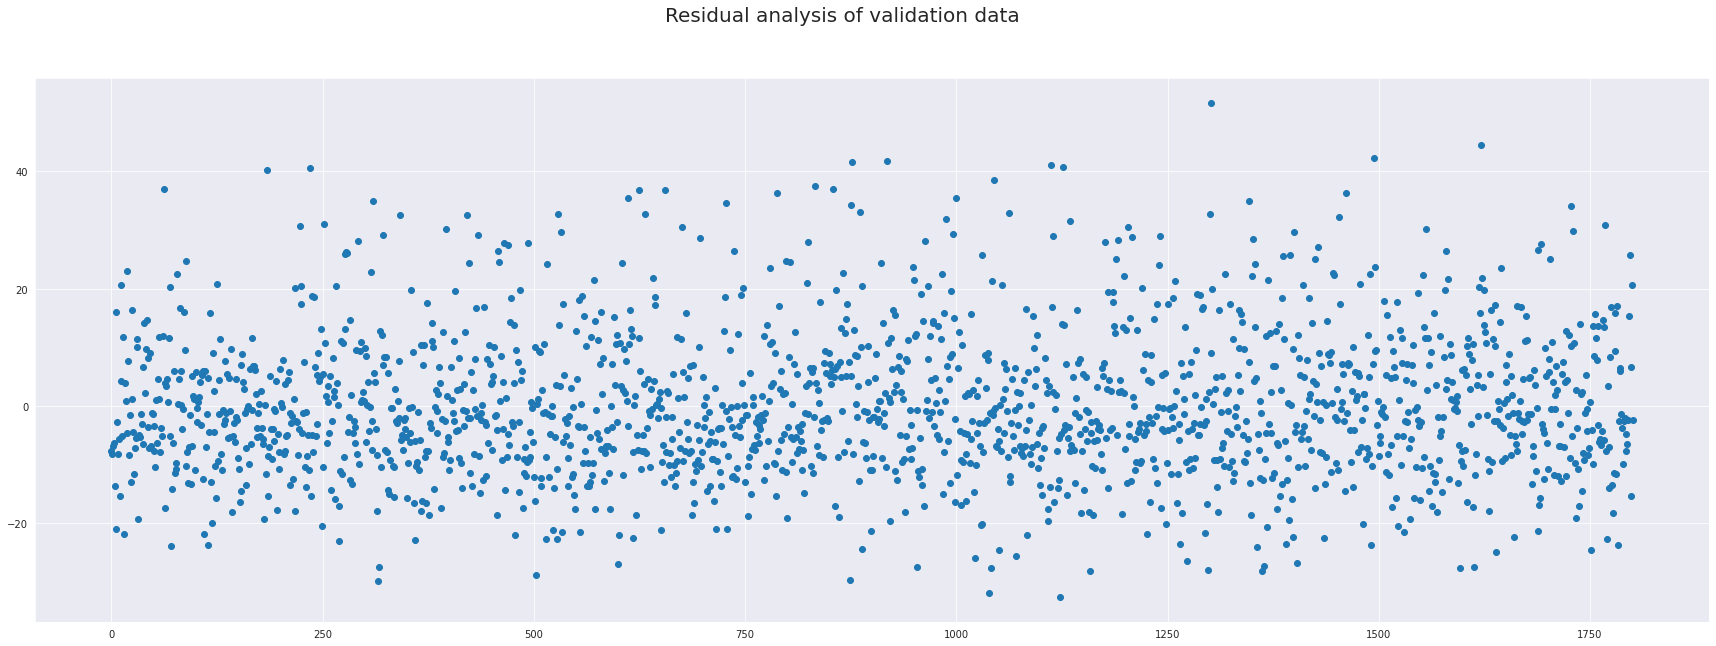

In [20]:
res = y_test - val_preds_base
plt.figure(figsize = (30,10))
plt.scatter(x = [i for i in range(len(res))], y = res)
plt.suptitle("Residual analysis of validation data ", fontsize = 20)
del res
plt.show()

# 📈 Partial Dependency Plots 📈
* Partial dependecy plots show how changes in certain features inmpact the classification 
* This can give us information on additional features and how our models classifies our training data

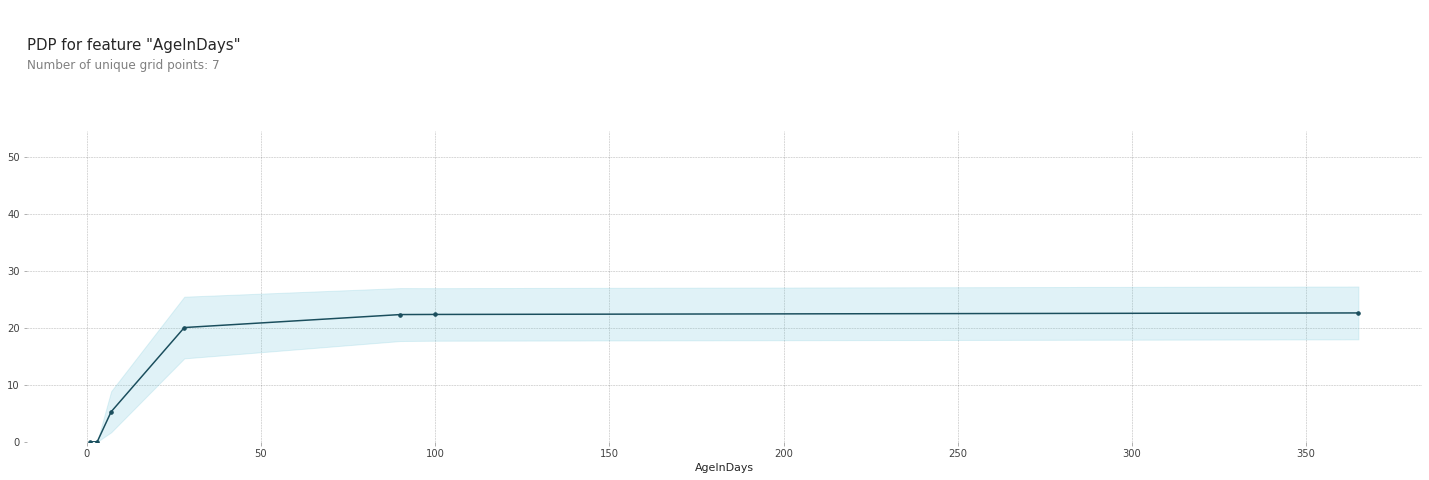

In [21]:
from pdpbox import pdp, get_dataset, info_plots
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train
                           , model_features=X_train.columns
                           , feature='AgeInDays')
pdp.pdp_plot(pdp_dist, feature_name='AgeInDays',figsize =(25,8))
plt.tight_layout()
plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes: </span></b>
    
* From the above graphs we see how the target value (y axis) changes as the values of 'squareMeters' changes 
* If we want to better predict our Housing Price we might want to further feature engineer '**squareMeters**'
* "**basement**" feature doesnt seem to increase or decrease the target

# ☘️ Feature importance ☘️

## 1. Intrinsic model feature importance
* As we are using lightgbm as our base model we can get an output of the models feature importance. 

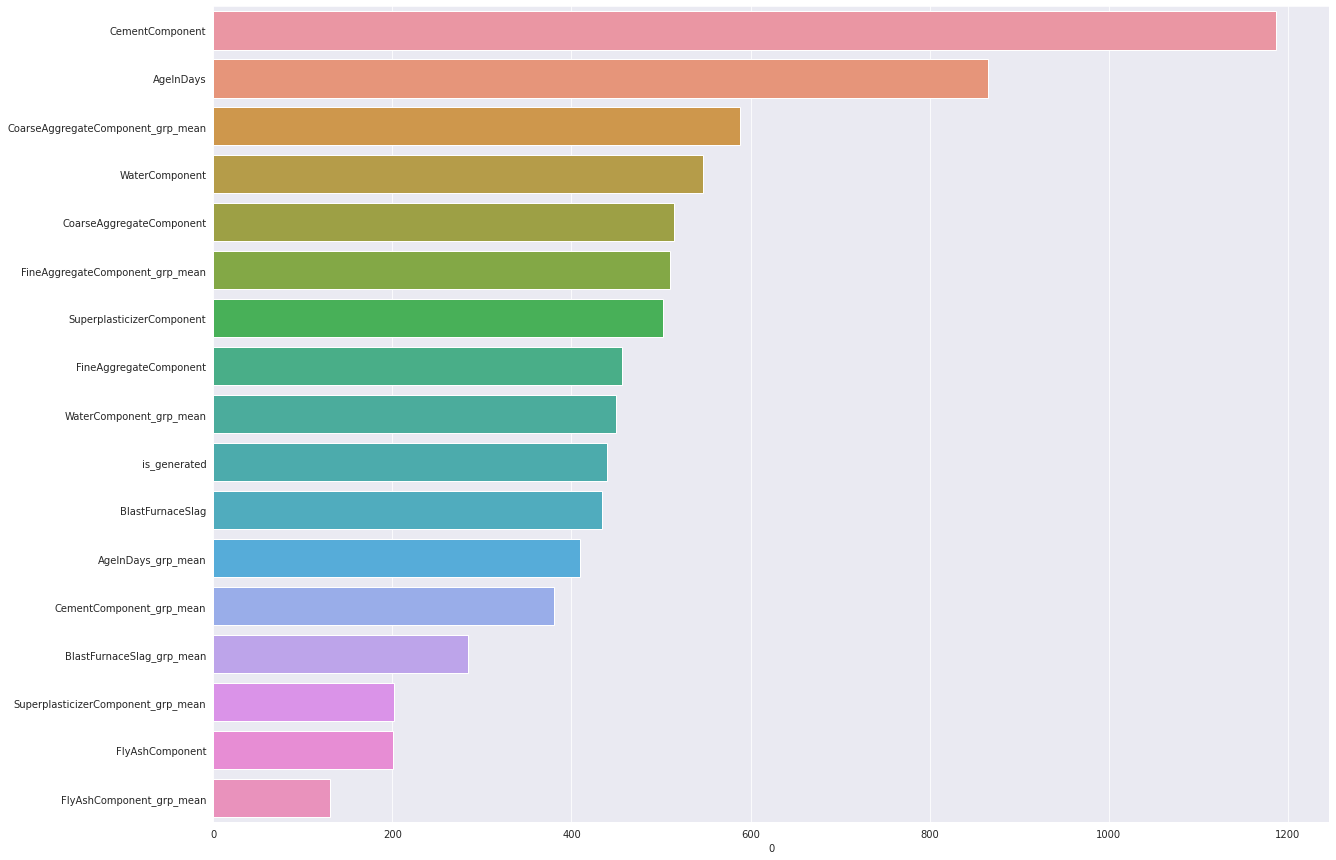

In [22]:
importances = pd.DataFrame(data = model.feature_importances_, index = model.feature_name_).sort_values(ascending = False , by =0)

plt.figure(figsize = (20,15))
sns.barplot(x = importances[0], y= importances.index)
plt.show()

## 2. Shap values 
[Shap values](https://shap.readthedocs.io/en/latest/index.html) are a good indicator of the **degree of feature importance** 
* We use multiple visualization methods to assists when plotting shap values from our fitted model

 
<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes on Shap Values   </span></b>
    
Shape values determine how the prediction was impacted. A **High** Shap value means that the predictive was influenced positively:
i.e. if the output is a probability from 0 to 1
* A high (postive) shap value will increase the prediction towards 1 (denoted as **RED** color)
* A low (negative) shap will decrease the prediction towards 0 (denoted as **BLUE** color

In [23]:
shap.initjs() # for visualization 

#Get Shap values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

<span style="color:orange;font-size:1.8em;">Target Interaction (by shap feature importance) </span>

### Summary Plot
The shap summary plot gives us an indication of feature importance. We need to pay specific attention to features with **high** average shap values as well as those that are zero:
* Zero valued features are good candidates for removal 
* High average shap values are good candidates for feature engineering. We can get ideas for feature engineering by viewing **shap.dependeceplots** and **shap.force_plots** (see below) to see the relationship of features

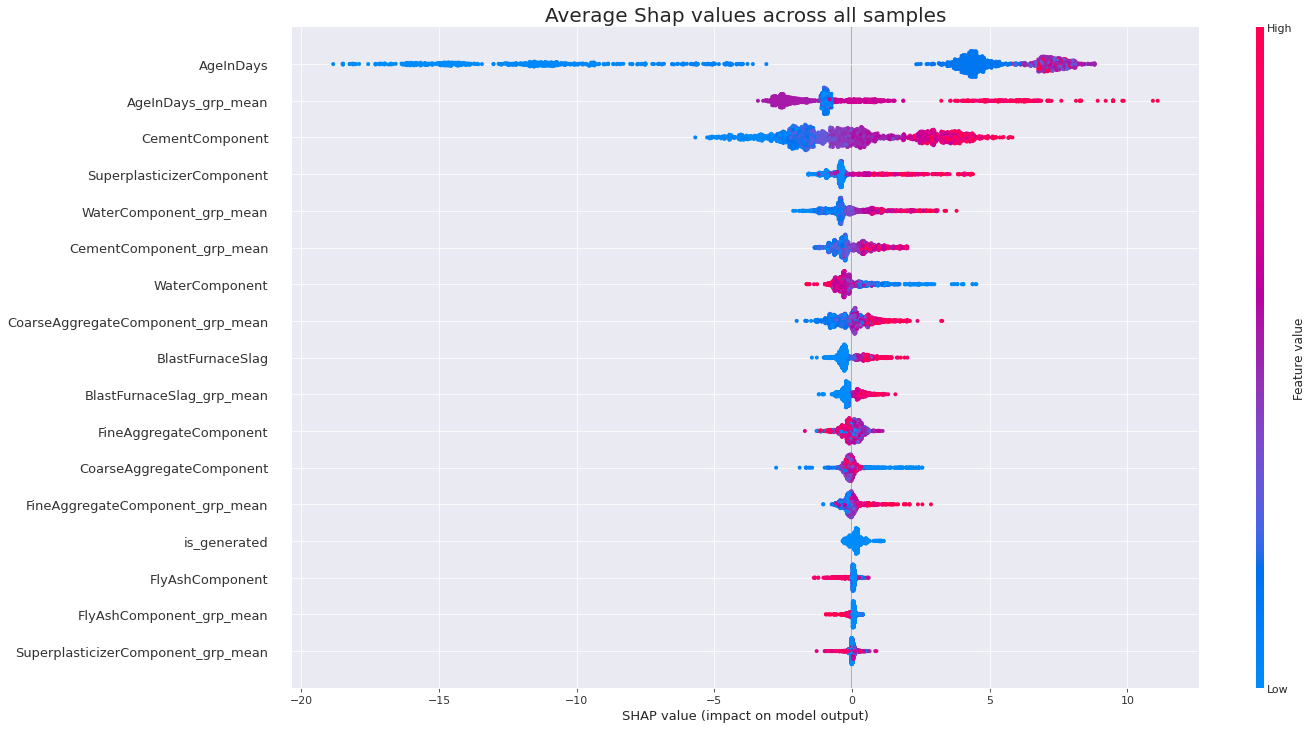

In [24]:
shap.summary_plot(shap_values, X_test,max_display = 400, plot_size = [20,10], show= False)
plt.title("Average Shap values across all samples", fontsize = 20)
plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes: </span></b>
    
* Certain features may have zero average shap value. As such they dont play a part in the models prediction. 
    * We can test our model again without these features to see if there is a model improvement (i.e. drop  column)
* Additionally, the graphs also give us ideas on new features we can create:
    * i.e. **squareMeters** as noted previously is very important. Can we create more features using this feature i.e. cutoff, bins or filter feature or mathematical operations or groupings to the other features

### Force Plot
The forceplot above looks at a number of samples and shows how certain (important) features influenced the final model prediction i.e. How these features push the model to predict the target

In [25]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0:1,:])

<div class='alert alert-block alert-success'><b><span style="color:blue;font-size:1.2em;"> </span></b>
Below is a force_plot of ALL the samples, use the dropdowns on the x and y axis to filter by specific features

In [26]:
#shap.force_plot(explainer.expected_value, shap_values, X_test)

<span style="color:orange;font-size:1.8em;">Feature Interaction / Feature Dependency </span>
    
Below we look at the interaction and relationship **between features** 

#### Interaction Values
Shap Interaction values are the fantastic as visualizing how features affect others in relation to the models prediction 

In [27]:
# # Get interaction values
# shap_interaction_values = explainer.shap_interaction_values(X_test)

### 1. Heatmap plot of shap interaction values 

Taken from [analysing interactions with shap](https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a):
1. To start we will calculate the absolute mean for each cell across all matrices. 
2. We take the absolute values as we do not want positive and negative SHAP values to offset each other. 
3. Because the interaction effects are halved, we also multiply the off diagonals by 2. 
4. We then display this as a heatmap.


#### 1a Absolute mean shap interactions 
* We get the **absolute mean** of the shap interactions 
 * the absolute of the values gives us the magnitude of the interaction and includes both negative and postive probability (i.e. adds them together as positives) 
 * if we want the overall result , we must remove the absolute calculation and only calculate the mean shap interactions 

In [28]:
# # Get absolute mean of matrices
# abs_mean_shap = np.abs(shap_interaction_values).mean(axis =0)

In [29]:
# fig,ax = plt.subplots(figsize = (25, 12)) 

# df = pd.DataFrame(abs_mean_shap, index=X_test.columns, columns=X_test.columns)
# df.where(df.values == np.diagonal(df),df.values*2, inplace=True)
# sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=True )

# ax.tick_params(axis='x', labelsize=10, rotation=90)
# ax.tick_params(axis='y',  labelsize=10)
# plt.suptitle("Absolute Mean Shap Interaction Values (Magnitude of effect on model predictions)",fontsize=15)
# plt.tight_layout(pad = 4)
# plt.show()

Lets remove the upper triangle and therefore remove the high squareMeters value

In [30]:
# fig,ax = plt.subplots(figsize = (25, 12)) 

# df = pd.DataFrame(abs_mean_shap, index=X_test.columns, columns=X_test.columns)
# df.where(df.values == np.diagonal(df),df.values*2, inplace=True)
# upper_triangle = np.triu(np.ones_like(df, dtype=bool))
# sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=True , mask= upper_triangle )

# ax.tick_params(axis='x', labelsize=10, rotation=90)
# ax.tick_params(axis='y',  labelsize=10)
# plt.suptitle("Absolute Mean Shap Interaction Values (Magnitude of effect on model predictions)",fontsize=15)
# plt.tight_layout(pad = 4)
# plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes: </span></b>
    
* Again **squareMeters** is the deciding feature
* However on the second heatmap we see some interaction with **garage** size and **squareMeters**
    * Lets look at the dependency of these features

#### 1b Mean shap interactions 
* Gives us the feature interaction value that and the overall push that these features have on the models prediction i.e. red = high probability of class 

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes: </span></b>
As this is a Regression problem, this wont make much sense as we wont know the value of the feature vs the impact to Target (it makes more sense with Classification problems)

In [31]:
# Get absolute mean of matrices
# mean_shap = np.array(shap_interaction_values).mean(axis =0)

In [32]:
# fig,ax = plt.subplots(figsize = (25, 12)) 

# df = pd.DataFrame(mean_shap, index=X_test.columns, columns=X_test.columns)
# df.where(df.values == np.diagonal(df),df.values*2, inplace=True)
# sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=True  )

# ax.tick_params(axis='x', labelsize=10, rotation=90)
# ax.tick_params(axis='y',  labelsize=10)
# plt.suptitle("Mean Shap Interaction Values (Overall effect on model predictions)",fontsize=15)
# plt.tight_layout(pad = 4)
# plt.show()

#### Dependence plots
* Dependence plots require a lot of investigation and testing. We look at the relationship of 2 features and how they influence the **shap values** and **shap interactions**  (i.e. the model output) 
* Below I took a feature with a high average Shap value (see summary plot i.e. alcohol) and look at its relationship with features that interact highly with it (see heatmaps above). This will hopefully allow us to find any additional feature we can create (i.e clip values, multiply/Add/Subtract features , polynomial features etc) 

In [33]:
# fig = plt.figure()
# for i in range(1,7):
#     axes = fig.add_subplot(2,3,i)
#     shap.dependence_plot("squareMeters", shap_values, X_test, display_features=X_test, interaction_index=i, show=False,ax= axes)
# plt.gcf().set_size_inches(30,15)
# fig.suptitle("Shap Dependency plots for squareMeters vs other features", fontsize = 20)
# plt.tight_layout(pad =3)
# plt.show()

# 🧊  Muti-Model Testing 🧊 
In this section we will test multiple models. This will allow use to understand which model would be best to optimize as well as allow use to ensemble models once optimized (note that we dont optimize the models in this notebook) 
The models we test should be quite broad however we can lump these into 3 categories:
* Linear i.e. Logistic regression for general linear modelling, Ridge when we dnt have optimal features selected (Ridge regularizes features) and Support Vector Machines for additional kernalization
* Trees i.e. gradient boosting such as LightGBM and XGBoost with ensemble trees convered by Random Forests and Extra Trees  
* Neural networks (see below)

**On Neural network exclusion**:\
As this is a tabular problem (not an image or text based) I will assume that neural networks wont do as well for this problem. This is also quickly apparent when looking at the data which is not homogenous in nature (i.e similar distributions, scale and source) this is usually an indicator that Neural networks wont do well with this problem 
Also due to their long run time and complexity I will note include here 


<span style="color:orange;font-size:1.5em;">Solution Implementation: Skewness,  Outliers , Scaling & Imbalanced data </span>
* **Quantile Scaling** for non-stributed features should normalise our data  
* **Robust Scaling** for outlier identification
* **Standard Scaler** for linear models to assist convergence, which we will apply to all the other columns that arent outliers or skew 
* **SMOTE** to oversample our data as our classes are imbalanced 

##### Note: At the beggining of this notebook we set the paramaters to turn the above on or off. This is for testing purposes i.e. run this notebook with different paramaters to test model improvement

In [34]:
lgb_params ={'objective': 'regression',# regression_l1, huber, fair, poisson, quantile, mape, gamma, tweedie
             "metric":"rmse", 
             "boosting_type": "gbdt",#"dart",gbdt
             'reg_alpha': 1, 
#              'lambda_l2': 9.938606206413121,
#              'num_leaves': 44,
              'colsample_bytree': 0.8,
#               'subsample': 0.8,
#             'bagging_freq': 6,
#              'min_data_in_leaf': 134,
#              'min_child_samples': 70,
#              'max_depth': 9,   
             'n_estimators':EPOCHS,
             'learning_rate':0.1,
            'device':'cpu'}

xgb_params = { 
    'objective' : "reg:squarederror",
    'n_estimators' : EPOCHS, 
    'early_stopping_rounds' :30,
    'eval_metric' : "rmse",
    'learning_rate': 0.55,
    #'max_depth': 5,
    'booster' : 'gbtree'#'gbtree',dart
             }
cat_params = {'iterations':EPOCHS,
              'eval_metric' : "RMSE", 
              'learning_rate': 0.08,
              'loss_function':'RMSE',
              "depth" : 6,
              "l2_leaf_reg": 9,
              'random_strength': 1,
              #"bagging_temperature": 500,
              "grow_policy":"SymmetricTree" #"Depthwise"
             }

ET_params = {'max_depth':10, 'n_estimators':EPOCHS, #'max_features' :'sqrt', #log2 None
             #'bootstrap':False
            }
RF_params = { 'max_depth':7,'n_estimators':EPOCHS,
            }

GR_params = {'loss':'squared_error',
    'learning_rate':0.008,
    'n_estimators':EPOCHS,
    'subsample':1.0,
    'criterion':'friedman_mse',# squared_error
    'min_samples_split':2,
    'min_samples_leaf':1,
    'min_weight_fraction_leaf':0.0,
    'max_depth':3,
    'min_impurity_decrease':0.0,
    'max_features':None,
    #'alpha':0.9,
    'verbose':0,
    'max_leaf_nodes':None,
    'warm_start':False,
    #'validation_fraction':0.1,
    'n_iter_no_change':None,
    'tol':0.0001,
    'ccp_alpha':0.0}

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=30,restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1 ,patience=5,min_lr=0.001)

In [35]:
# Comment out the models below to include in the Crossvalidation 

models = {
    "LinearRegression": LinearRegression(),
     "SVR":SVR( kernel = "rbf",max_iter = EPOCHS+2000), #linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
    "Ridge":Ridge(alpha=430,max_iter = EPOCHS),
    "Gradient": GradientBoostingRegressor(**GR_params),
     "lightgbm": lgb.LGBMRegressor(**lgb_params), 
    "xgboost": xgb.XGBRegressor(**xgb_params), 
    "catboost": cat.CatBoostRegressor(**cat_params),
     "ExtraTree": ExtraTreesRegressor(**ET_params),
     "RandomForest":RandomForestRegressor(**RF_params),
    "nn":tf.keras.Sequential([
         tf.keras.layers.Dense(128, activation="selu"),
         #tf.keras.layers.Dropout(0.2),
         tf.keras.layers.Dense(64, activation="selu"),
         #tf.keras.layers.Dropout(0.2),
         tf.keras.layers.Dense(32, activation="selu"),
         #tf.keras.layers.Dropout(0.2),
         tf.keras.layers.Dense(16, activation="selu"),
         #tf.keras.layers.Dropout(0.2),
         tf.keras.layers.Dense(8),
         #tf.keras.layers.Dropout(0.2),
         tf.keras.layers.Dense(1)    ]) 
}

## Cross Validation

In [36]:
kfold= RepeatedKFold(n_splits=NUM_FOLDS,n_repeats=NUM_SPLITS)

In [37]:
non_dist_cols = [col for col in non_dist_cols if col in df_trn.columns]
print("skew columns:\n", non_dist_cols)
outliers = [col for col in outliers if col not in list(non_dist_cols) + pca_cols and col in df_trn.columns]
print("outliers:\n", outliers)
scaled_cols = [col for col in df_trn.drop(target,axis =1).columns if col not in outliers + list(non_dist_cols) +pca_cols]
print("scaled_cols:\n", scaled_cols) 

if len(scaled_cols)==0:
    SCALING = False

skew columns:
 ['AgeInDays']
outliers:
 ['WaterComponent']
scaled_cols:
 ['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'is_generated', 'CementComponent_grp_mean', 'BlastFurnaceSlag_grp_mean', 'FlyAshComponent_grp_mean', 'WaterComponent_grp_mean', 'SuperplasticizerComponent_grp_mean', 'CoarseAggregateComponent_grp_mean', 'FineAggregateComponent_grp_mean', 'AgeInDays_grp_mean']


In [38]:
def cross_val(X,y, df_tst_in):

    score_train = []
    score_val= []
    score2_val = []
    OOF_preds = []
    list_shap_values= []
    OOF_trn_preds = []   
    best_models_all =[]

    if TEST_ON_GENERATED_ONLY:
        index_ = X[X["is_generated"]==1].index
        OOF_val_preds=  pd.DataFrame(0, index = y[index_].index , columns =[target])
    else:
        OOF_val_preds= pd.DataFrame(0, index = y.index , columns = [target])

    for fold, (train_idx,val_idx) in enumerate(kfold.split(X,y)):
        X_train,y_train = X.iloc[train_idx,:], y.iloc[train_idx]
        X_test,y_test = X.iloc[val_idx,:], y.iloc[val_idx]
        print("\n###### FOLD",fold,"######")

        if TEST_ON_GENERATED_ONLY:
            index_val = X_test[X_test["is_generated"]==1].index
            y_test = y_test[index_val]
            X_test = X_test.loc[index_val, :]
            val_idx = index_val

        # run for each model and get best model (through score comparison of each model)
        best_score_val = 1e10
        best_score_trn= 1e10
        best_preds_val = None
        best_preds_trn= None
        best_preds_test = None
        best_model = None
        best_X_s = None
        best_test_s = None
        best_name = None

        for name, model in models.items():

            #Scaling
            if name in ["LinearRegression",'Ridge', "SVR"]:
                scaler = StandardScaler()
                X_train_s = scaler.fit_transform(X_train)
                X_test_s  = scaler.transform(X_test)
                X_temp = X.copy(deep = True)
                X_temp = scaler.transform(X_temp)
                test_temp = scaler.transform(df_tst_in)
                y_train_s = y_train.copy(deep = True)
                
            elif SCALING:
                X_train_s, X_test_s , test_temp, X_temp = Scaling(X_train, X_test , df_tst_in, X )
            else:
                X_test_s = X_test.copy(deep = True)
                X_train_s = X_train.copy(deep = True)
                X_temp = X.copy(deep = True)
                test_temp = df_tst_in.copy(deep = True)
                y_train_s = y_train.copy(deep = True)


            #Fit
            test_preds_fold, trn_preds_fold, val_preds_fold, score_train_fold, score_val_fold, model_out = base_model(X_train_s,y_train_s,X_test_s,y_test, name,model, X_temp, test_temp, False)

            print(name, "with score of:", score_val_fold, "and score2:",SMAPE(y_test, val_preds_fold) )
            if score_val_fold < best_score_val:                
                best_score_val = score_val_fold
                best_score_trn= score_train_fold
                best_preds_val = val_preds_fold
                best_preds_trn= trn_preds_fold
                best_preds_test = test_preds_fold
                best_model = model_out
                best_X_s = X_temp
                best_test_s = test_temp
                best_name= name


        # use best model for predictions    
        print("\nbest model:",best_name,"best score",best_score_val, "score2:",SMAPE(y_test, best_preds_val) )
        best_models_all.append(best_name)
        OOF_val_preds.loc[val_idx, target] = OOF_val_preds.loc[val_idx, target] + best_preds_val/NUM_SPLITS

        score_val.append(best_score_val)
        score2_val.append(SMAPE(y_test, best_preds_val))
        score_train.append(best_score_trn)
        OOF_trn_preds.append(best_preds_trn )
        OOF_preds.append(best_preds_test)

        #Shap values of best model
        if SHAP_VALS:
            explainer = shap.Explainer(best_model)
            shap_values_cv = explainer.shap_values(best_test_s)
            list_shap_values.append(shap_values_cv)

        print("Trn score:",best_score_trn)
        print("Val score:",best_score_val)
        print("Val Score2:",SMAPE(y_test, best_preds_val))


    if TEST_ON_GENERATED_ONLY:
        print("\nMEAN Trn score:",np.mean(score_train))
        print("MEAN Val score:",mean_squared_error(y[index_], OOF_val_preds.mean(axis =1))**0.5)
        print("MEAN Val Score2:",SMAPE(y[index_], OOF_val_preds.mean(axis =1)))
    
    else:
        print("\nMEAN Trn score:",np.mean(score_train))
        print("MEAN Val score:",mean_squared_error(y, OOF_val_preds.mean(axis =1))**0.5)
        print("MEAN Val Score2:",SMAPE(y, OOF_val_preds.mean(axis =1)))
    
    if SHAP_VALS:
        return OOF_preds, OOF_trn_preds, OOF_val_preds, score_train, score_val, best_models_all, list_shap_values
    else:
        return OOF_preds, OOF_trn_preds, OOF_val_preds, score_train, score_val, best_models_all

In [39]:
if SHAP_VALS:
    test_preds, train_preds, val_preds, OOF_trn_score, OOF_val_score, best_models, shap_values = cross_val(X,y, df_tst)
else:
    test_preds, train_preds, val_preds, OOF_trn_score, OOF_val_score, best_models = cross_val(X,y, df_tst)


###### FOLD 0 ######
LinearRegression with score of: 11.899720981850214 and score2: 28.859849796889947
SVR with score of: 12.093565077826646 and score2: 28.87219640653875
Ridge with score of: 11.90410532269727 and score2: 28.96890880684245
Gradient with score of: 11.652255345232753 and score2: 28.29161920391181
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[39]	valid_0's rmse: 11.6439
lightgbm with score of: 11.643944101987971 and score2: 28.292102306402622
xgboost with score of: 11.646347614339424 and score2: 28.231690216735274
catboost with score of: 11.630896028235947 and score2: 28.208952195330653
ExtraTree with score of: 11.639164437153136 and score2: 28.471216902051562
RandomForest with score of: 11.621553771999679 and score2: 28.360120802986952
nn with score of: 11.706521138198989 and score2: 28.421052751919788

best model: RandomForest best score 11.621553771999679 score2: 28.360120802986952
Trn score: 10.795678920662349
Val sc

In [40]:
if TEST_ON_GENERATED_ONLY:
    val_score = mean_squared_error(y[X[X["is_generated"]==1].index],val_preds )**0.5
else:
    val_score = mean_squared_error(y,val_preds )**0.5
val_score

11.928654352581242

In [41]:
best_models

['RandomForest',
 'catboost',
 'nn',
 'nn',
 'nn',
 'lightgbm',
 'nn',
 'catboost',
 'catboost',
 'nn',
 'nn',
 'nn',
 'nn',
 'nn',
 'catboost']

# Shap Values

In [42]:
shap.initjs() # for visualization 

In [43]:
# this is the ABSOLUTE MEAN ( i.e the magnitude of the shap values )
if SHAP_VALS:
    folds = NUM_SPLITS* NUM_FOLDS

    shap_values_cv = np.abs(shap_values[0])/folds

    for i  in range(1,len(shap_values)):
        shap_values_cv = shap_values_cv +(np.abs(shap_values[i]))/folds

    shap.summary_plot(shap_values_cv, df_tst,max_display = 4000, plot_size = [30,20], show= False)
    plt.title("Total Shap values across all folds", fontsize = 20)
    plt.show()

## Shap interaction values
The interaction plots help us understand how our each feature "interacts" with the others with respect to our models predictio
I have excluded interaction value as it uses too much memory to concatenate all the values from the CV (however we can do this for one model if needed)

In [44]:
# #Get Shap values
# explainer_i = shap.Explainer(model)
# shap_values_ = explainer.shap_values(test_temp)
# # Get interaction values
# shap_interaction_values = explainer_i.shap_interaction_values(test_temp)

## Setup submissions 

In [45]:
sub[target]  = 0
sub_base =  sub.copy(deep= True)
sub_ensemble = sub.copy(deep= True)
sub_best_cv = sub.copy(deep= True)
sub_cal = sub.copy(deep = True)
mean_ensemble = sub.copy(deep = True)

In [46]:
# Base model submission
sub_base[target]=test_preds_base
print("Base Model (lightgbm) values (inital 5 rows):")
sub_base.to_csv("submission_base.csv")
sub_base.head()

Base Model (lightgbm) values (inital 5 rows):


,Strength
id,
5407,45.774760
5408,19.896651
5409,32.518287
5410,47.530892
5411,34.119327


In [47]:
# Best CV model submission 
sub_best_cv_trn = y.copy(deep = True)
sub_best_cv_trn = train_preds[np.argmax(OOF_val_score)]

sub_best_cv[target] = test_preds[np.argmax(OOF_val_score)]
print(f"Best CV split score: {np.max(OOF_val_score):.4f}")

Best CV split score: 12.3703


In [48]:
best_cv_score = mean_squared_error(y,sub_best_cv_trn )**0.5
print("Best CV Score",best_cv_score)

sub_best_cv.to_csv(f"sub_best_cv_{best_cv_score:.4f}.csv")
sub_best_cv.head()

Best CV Score 11.516899714351169


,Strength
id,
5407,46.149525
5408,19.258347
5409,29.124041
5410,47.086895
5411,27.755177



<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;"> Question: Why did Random Forest do well  </span></b>

Now that we can see our Cross Validation scores we can get an insight into how certain Algorithms work with our data
* We know that Random Forest does **boostrapping** of samples and **feature selection**, therefore we can deduce that either:
 * Certain features are negatively affecting our models performance (as all features are used in lightgbm and xgboost)
 * Certain samples are negatively affecting our models performance i.e. outliers 
 
<span style="color:red;font-size:1.3em;">Potential Solutions </span>
* Determine if Random Forest is impacted by bootstrapping or features selected
 * **Boostrapping**: check our scaling and distribution techniques to make sure we are identifying outliers. Also add better features 
 * **Features selected**: decomposition of features through dropping features and PCA of correlated features
 

# 🥣 Ensembling 🥣
There are a number of ensembling techniques and I will state below my most used:
1. <span style="color:orange;font-size:1em;">Mode, Hard Voting, Soft Voting Ensemble</span>
2. <span style="color:orange;font-size:1em;">Weighted Average Ensemble</span> 
3. <span style="color:orange;font-size:1em;">Hill Climbing</span> ==> iterative process: adding predictions to others and multipling by random weights to find the best (**Note:** This can be quite complicated and I do use this process in this notebook) 
4. <span style="color:orange;font-size:1em;">Optimization methods</span> ==> Similar to High Climbing however it uses specialised optimization algorithms (please see link bellow on how to implement)

More on how these are implemented please check out my [notebook here ](https://www.kaggle.com/code/slythe/post-ensembling-hill-climbing-weighted-scipy)

### Hard and Soft Voting
As we are looking at a multi-class classification problem. We can ensemble a few other ways such as 
* Mode: Get the **most frequent prediction** from all the models i.e. four models predicted the class as 3 and two models predicted the class as 1, therefore we use class 3 (most frequent) 
* Soft-Voting (also called Mean Ensembling): Sum all the **probabilities** and divide by the number of models to get the **mean probabilities**
 * This is only effective if the models are optimized (which ours arent) 
* Hard Voting: Identify the **highest probability** accross all models, this is the prediction 
    * This is usually better than Soft-voting when model are NOT optimized by less so if they models are optimized 

In [49]:
# Get a dataframe of train and test predictions 
all_trn_preds = pd.DataFrame(index = df_trn.index)
all_tst_preds = pd.DataFrame(index = df_tst.index)

for i, preds in enumerate(train_preds):
    all_trn_preds[f"{OOF_val_score[i]}"] = train_preds[i]
    all_tst_preds[f"{OOF_val_score[i]}"] = test_preds[i]
all_tst_preds

,11.621553771999679,12.183339710560663,11.807830283206593,12.37034394348054,11.962121252099056,12.09638093400534,12.054604724387056,11.906467183591765,12.074072455653852,11.693223987647158,12.075762547362597,11.950252246370045,12.036041512836267,12.007831630937588,11.913289377156278
id,,,,,,,,,,,,,,,
5407,47.625340,48.903513,47.366344,46.149525,45.620777,47.081477,47.632751,46.337817,46.982809,47.464581,46.726048,46.303360,46.544563,47.760632,47.226619
5408,20.579866,21.002509,19.892000,19.258347,19.598217,21.095023,19.965424,21.992025,22.675482,18.841209,21.365324,19.838453,19.344206,18.120394,21.601939
5409,33.790106,31.138410,31.925972,29.124041,26.689152,32.239601,29.626383,32.731708,31.894082,31.033909,30.981621,29.622015,28.935093,27.964254,32.314539
5410,45.967795,47.676643,46.980045,47.086895,46.312592,45.747205,47.989746,48.056731,47.962852,48.613708,47.917171,48.187775,47.625290,47.342014,46.521702
5411,29.903326,32.133182,32.008236,27.755177,32.352455,32.160177,31.108408,32.543927,31.983932,29.947021,34.456440,29.506742,28.101337,30.621696,33.005481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007,32.231061,32.785925,32.715736,31.076597,31.408413,31.597640,32.529797,33.032108,32.745399,32.198483,32.081783,31.350040,31.278051,31.413528,32.458345
9008,36.788454,33.769629,34.101143,32.917252,32.121052,34.196669,32.368084,34.889655,34.855303,33.721954,33.719097,31.793665,31.033457,30.073833,34.854260
9009,38.068092,40.030419,40.271526,38.949219,38.747513,41.375542,40.574741,39.944540,39.582780,41.568096,40.968300,40.432507,39.579548,40.742577,39.232497


#### Soft Voting (Mean) Ensembling

In [50]:
# Get mean ensemble
mean_tst_preds = all_tst_preds.mean(axis =1)
mean_trn_preds =  all_trn_preds.mean(axis =1)

mean_ensemble[target]= mean_tst_preds.values

In [51]:
mean_score = mean_squared_error(y,mean_trn_preds )**0.5
print("Mean Score",mean_score)

mean_ensemble.to_csv(f"mean_ensemble_{mean_score:.4f}.csv")
mean_ensemble

Mean Score 11.230776021697976


,Strength
id,
5407,47.048410
5408,20.344694
5409,30.667392
5410,47.332544
5411,31.172503
...,...
9007,32.060194
9008,33.413567
9009,40.004526


## Weighted Ensembling
* Multiple the predictions by their relative score (wieght) and divide by the sum of the scores 
* In this notebook I will focus on **weighted ensembling** as this usually gets decent results for very little coding

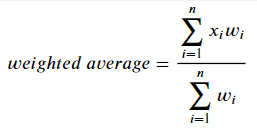

In [52]:
sub_ensemble_trn = y.copy(deep = True)

for i, preds in enumerate(test_preds):
    sub_ensemble[target] = sub_ensemble[target] + (test_preds[i] * OOF_val_score[i]) #multiply preds by their corresponding auc score
    sub_ensemble_trn= sub_ensemble_trn + (train_preds[i] * OOF_val_score[i])
    
sub_ensemble_trn =   (sub_ensemble_trn/ sum(OOF_val_score) ).values
sub_ensemble[target] =   (sub_ensemble[target]/ sum(OOF_val_score)).values 


In [53]:
weighted_score = mean_squared_error(y,sub_ensemble_trn )**0.5
print("Weighted Score",weighted_score)

sub_ensemble.to_csv(f"sub_weighted_ensemble_{weighted_score:.4f}.csv")
sub_ensemble.head()

Weighted Score 11.166702289680334


,Strength
id,
5407,47.046939
5408,20.345896
5409,30.656106
5410,47.333360
5411,31.170515


## Optimized Ensembling
NB this is on train preds which is not ideal, ideally we should be using validation preds

In [54]:
from scipy import optimize
from functools import partial

class OptimizedEnsemble(object):
    def __init__(self):
        self.coef_ = 0    

    def _rmse_loss(self, coef, X, y):   
        ensemble = np.zeros(len(X))
        for i,col in enumerate(X.columns):
            ensemble = ensemble + coef[i] * X[col] 
        ll = mean_squared_error( y, ensemble )**0.5
        return ll

    def fit(self, X, y):
        loss_partial = partial(self._rmse_loss, X = X, y = y)
        initial_coef = [1/len(X.columns)]*len(X.columns)
        bounds = [(0,None)]* len(X.columns)
        constraints = ({'type': 'eq','fun': lambda w: 1-sum(w)}) #coefs must equal 1 i.e 1-sum(coefs) = 0
        self.coef_ = optimize.minimize(loss_partial, initial_coef,method= 'SLSQP', #'SLSQP','Nelder-Mead'
                                       bounds = bounds,constraints = constraints,
                                      options = {'ftol':1e-10})

    def predict(self, X, coef):
        ensemble = np.zeros(len(X))
        for i,col in enumerate(X.columns):
            ensemble = ensemble + coef[i] * X[col] 
        return ensemble

    def coefficients(self):
        return self.coef_['x']

In [55]:
opt = OptimizedEnsemble()
opt.fit(all_trn_preds,y)
coef = opt.coef_['x']
coef

array([5.59395746e-01, 0.00000000e+00, 0.00000000e+00, 2.94930096e-16,
       8.39985633e-17, 4.40604254e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.33988479e-16, 0.00000000e+00,
       2.57118545e-16, 1.81874914e-16, 1.37890188e-16])

In [56]:
opt_ensemble = opt.predict(all_trn_preds,opt.coef_['x'])
opt_score = mean_squared_error(y,opt_ensemble)**0.5
print(f"Mean RSME Opt: {opt_score:.4f}")

Mean RSME Opt: 10.7457


In [57]:
sub_opt = sub.copy(deep = True)
sub_opt[target] = opt.predict(all_tst_preds,opt.coef_['x'])
sub_opt.to_csv(f"sub_opt_{opt_score:.4f}.csv")
sub_opt.head()

,Strength
id,
5407,47.385711
5408,20.806847
5409,33.106947
5410,45.870602
5411,30.897704


# ✅ Post-Prediction Analysis & Manipulation ✅

#### i. Calibration: 
* Our models may not be optimized and a simple linear model trained on our training predictions may be able to smooth out any inconsistencies with our model through fitting and additional linear model on our predictions 

### i. Calibration
* We will calibrate our **test predictions** by fitting a linear regression model to a dataframe of our **training predictions** from each models Cross Validation. 
* This fitted calibrated model will then predict the **test predictions** and hopefully smooth out the values and provide a final test prediction 

In [58]:
CALIBRATION=='ridge'
if CALIBRATION == "linear":
    lin_model = LinearRegression()
elif CALIBRATION=='ridge': 
    lin_model = Ridge(alpha=2)

X_cal = all_trn_preds
OOF_val_scores_lin = []
OOF_trn_lin= []

OOF_val_lin=  pd.DataFrame(0, index = y.index , columns =[col for col in range(NUM_SPLITS*NUM_FOLDS)])

for fold, (train_idx,val_idx) in enumerate(kfold.split(X_cal,y)):
    X_train,y_train = X_cal.iloc[train_idx,:], y.iloc[train_idx]
    X_test,y_test = X_cal.iloc[val_idx,:], y.iloc[val_idx]
    
    test_preds_lin, trn_preds_lin, val_preds_lin, score_trn_lin, score_val_lin , model_out= base_model(X_train,y_train,X_test,y_test, "ridge",lin_model, X_cal, all_tst_preds, False)
    
    OOF_val_lin.loc[val_idx, fold] = OOF_val_lin.loc[val_idx, fold] + val_preds_lin/NUM_SPLITS
    
    OOF_val_scores_lin.append(score_val_lin)
    OOF_trn_lin.append(trn_preds_lin)
    
#cal_score = np.mean(OOF_val_scores_lin)
cal_score = mean_squared_error(y,OOF_val_lin.sum(axis =1))**0.5
cal_trn_preds  = np.mean(OOF_trn_lin,axis=0)
print(f"Mean RSME: {cal_score:.4f}")

Mean RSME: 10.3623


In [59]:
#readd_newdocfit on full data 
lin_model.fit(all_trn_preds, np.ravel(y)) # all_trn_preds
y_cal_test  = lin_model.predict(all_tst_preds)

full_fit_RSME = mean_squared_error(y, lin_model.predict(all_trn_preds))**0.5

print(f"Full fit RSME:{full_fit_RSME:.4f}")

sub_cal = sub.copy(deep = True)
sub_cal[target] = y_cal_test
sub_cal.to_csv(f"sub_cal_{cal_score:.4f}.csv")
sub_cal.head()

Full fit RSME:10.3359


,Strength
id,
5407,51.623369
5408,19.623363
5409,32.732205
5410,46.430758
5411,29.182487


# Save

In [60]:
sub_best_cv.to_csv("test_preds.csv")
val_preds.to_csv("val_preds.csv")
sub_best_cv

,Strength
id,
5407,46.149525
5408,19.258347
5409,29.124041
5410,47.086895
5411,27.755177
...,...
9007,31.076597
9008,32.917252
9009,38.949219


## Post-Prediction Analysis 

In [61]:
import gc
gc.collect()

5896

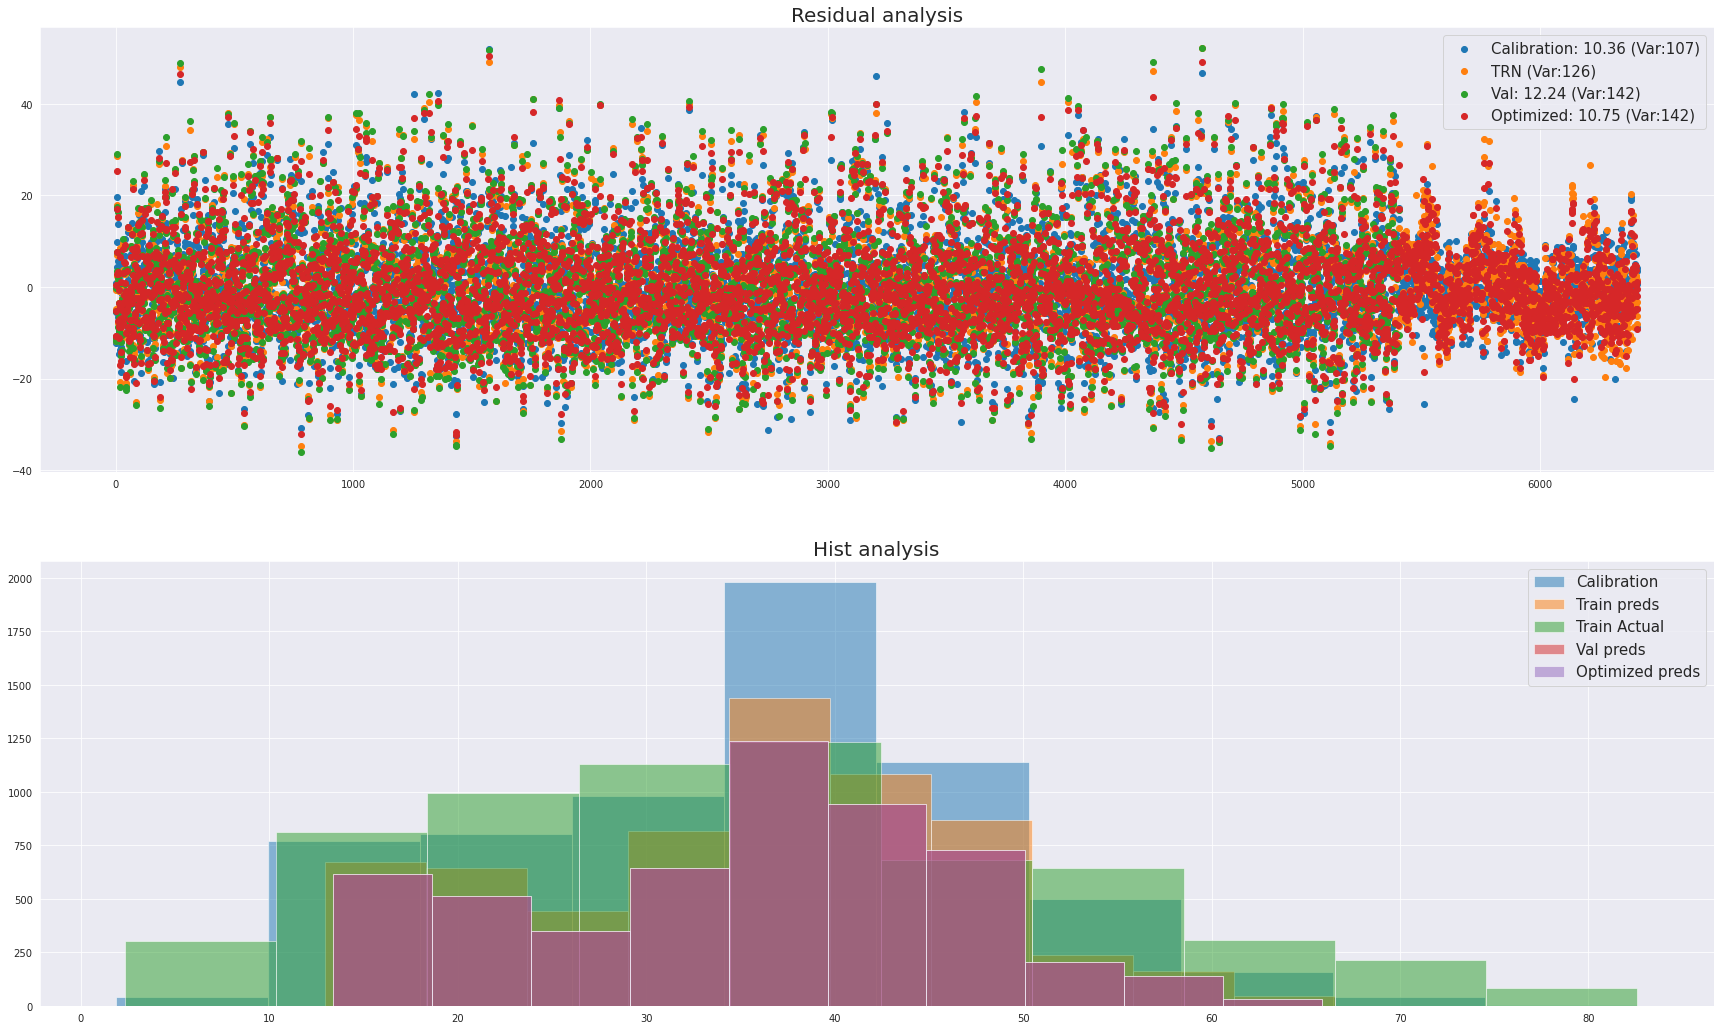

In [62]:
fig, ax = plt.subplots(2,1, figsize = (30,18))
ax = np.ravel(ax)



res_cal = y.values -cal_trn_preds
ax[0].scatter(x = [i for i in range(len(res_cal))], y = res_cal, label = f"Calibration: {cal_score:.2f} (Var:{np.var(res_cal):.0f})")
# ax[1].set_title("Train hist", fontsize = 12)
ax[1].hist(cal_trn_preds, label = f"Calibration", alpha = 0.5)

res_trn = y.values- all_trn_preds.mean(axis =1).values
ax[0].scatter(x = [i for i in range(len(res_trn))], y = res_trn ,label = f"TRN (Var:{np.var(res_trn):.0f})")
ax[1].hist(all_trn_preds.mean(axis =1).values, label = f"Train preds", alpha = 0.5)
ax[1].hist( df_trn[target], label = f"Train Actual", alpha = 0.5)

if TEST_ON_GENERATED_ONLY:
    res_val = y[X[X["is_generated"]==1].index].values - val_preds[target].values
else:
    res_val = y.values - val_preds[target].values
ax[0].scatter(x = [i for i in range(len(res_val))], y = res_val, label = f"Val: {score_val:.2f} (Var:{np.var(res_val):.0f})")
ax[1].hist(val_preds[target].values, label = f"Val preds", alpha = 0.5)

res_opt = y.values- opt_ensemble.values
ax[0].scatter(x = [i for i in range(len(res_opt))], y = res_opt, label = f"Optimized: {opt_score:.2f} (Var:{np.var(res_val):.0f})")
ax[1].hist(val_preds[target].values, label = f"Optimized preds", alpha = 0.5)

ax[0].set_title("Residual analysis", fontsize = 20)
ax[1].set_title("Hist analysis", fontsize = 20)

ax[0].legend(fontsize= 15)
ax[1].legend(fontsize= 15)
plt.show()

# Score

In [63]:
print(f"OOF TRN Score: {np.mean(OOF_trn_score,axis =0):.4f}")
print(f"OOF val Score: {val_score:.4f}")
print(f"Optimized Score (Train preds): {opt_score:.4f}")
print(f"Weighted Score: {weighted_score:.4f}")
print(f"Calibrated Score val: {cal_score:.4f}, trn :{full_fit_RSME:.4f}")

OOF TRN Score: 11.3313
OOF val Score: 11.9287
Optimized Score (Train preds): 10.7457
Weighted Score: 11.1667
Calibrated Score val: 10.3623, trn :10.3359


<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:2px;">
<b><span style="color:blue;font-size:1.2em;">Notes: Prediction Analysis </span></b>

*